---
title: "LSTM을 활용한 주택가격 예측"
date: 2020-07-03T18:00:47+09:00
tags:
  - "Basic Data Structures"
  - "Python Basic"
  - "Python"
  - "iteration"
categories:
  - "function"
  - "Python"
  - "Python Basic"
menu: 
  kaggle:
    name: How to create my own function
---

## LSTM과 RNN의 개요 
- RNN은 자연어처리에서 사용되는 대표적인 알고리즘
  + 순환신경망으로 표현됨
  + 활용범위: 음성 인식, 언어 모델링, 번역, 이미지 주석 생성

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile3.uf.tistory.com%2Fimage%2F9901A1415ACB86A0211095)

- Long Short-term Memory로 1997년에 소개되었음(Hochreiter and Schmidhuber, 1997). 
  + 논문: [Long Short-term Memory](https://www.researchgate.net/publication/13853244_Long_Short-term_Memory)

- LSTM 네트워크는 recurrent neural network(RNN)의 한 종류임. 
  + LSTM은 RNN의 특별한 한 종류로, 긴 의존 기간을 필요로 하는 학습을 수행할 능력을 갖고 있다.

- 간단하게 영어 단어를 맞춰보자. 
> The clouds are in the `...`

- 위 빈칸에 들어갈 단어의 옵션은 많지 않다. 
  + 즉, 우리는 위 단어가 `clouds`라는 것을 알게 된다. 

- 이번에는 조금 더 문장을 늘려나가보다. 
> I was born in Korea but grew up in France... Nevertheless, I speak fluent ...

- 한국어가 올지, 아니면 프랑스어가 올지 모른다. 

- 즉, 단기 기억은 `RNN`으로 해결할 수 있지만, 문장이 길어지고 복잡해지면 결과적으로 `LSTM` 알고리즘이 필요하다. 


## LSTM을 활용한 주식가격 예측 예제
- 캐글 데이터를 활용하여 주식 가격 예측을 합니다. 

In [83]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

### (1) 데이터 불러오기
- 데이터를 불러옵니다. 

In [84]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)
drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
from os.path import join  

MY_GOOGLE_DRIVE_PATH = 'My Drive/Colab Notebooks/ml_project' # 프로젝트 경로
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH) # 프로젝트 경로
print(PROJECT_PATH)

/content/drive/My Drive/Colab Notebooks/ml_project


In [86]:
%cd "{PROJECT_PATH}"

/content/drive/My Drive/Colab Notebooks/ml_project


In [87]:
stocks =  pd.read_csv('data/stock.csv', header=0)
stocks

,일자,시가,고가,저가,종가,거래량
0,20200107,55700,56400,55600,55800,9893846
1,20200106,54900,55600,54600,55500,10278951
2,20200103,56000,56600,54900,55500,15422255
3,20200102,55500,56000,55000,55200,12993228
4,20191230,56200,56600,55700,55800,8356767
...,...,...,...,...,...,...
9283,19850109,126,126,122,123,324836
9284,19850108,129,129,127,127,845098
9285,19850107,129,130,128,129,771895
9286,19850105,129,129,128,128,108496


### (2) 데이터 전처리 및 시각화
- 시각화를 위해 일자를 날짜형으로 변환한다. 

In [88]:
stocks['일자'] = pd.to_datetime(stocks['일자'], format='%Y%m%d')
# stocks['일자'] = pd.to_datetime(stocks['일자'], format='%Y-%m-%d')
stocks['연도'] = stocks['일자'].dt.year

- 연도는 1990년 이후로 재분류 한다. 

In [91]:
df = stocks.loc[stocks['일자']>="1990"]
# df = stocks.loc[(stocks['일자']>="1990") & (df['column_name'] <= B)]

- 이제 시각화를 작성한다. 
- 이 때, `거래량` & `종가`를 기준으로 구분해보고, 차이점에 대해 확인해본다. 

Text(0, 0.5, 'price')

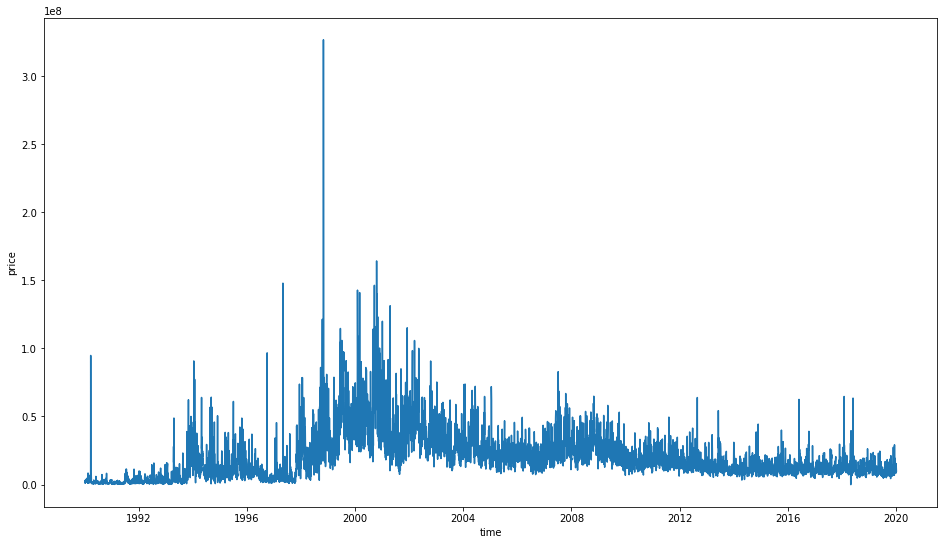

In [92]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['거래량'], x=df['일자'])
plt.xlabel('time')
plt.ylabel('price')

- 거래량이 가장 많았던 시기는 IMF 전후로 일어났다.
  + 왜 이 시기에 거래가 많이 일어났을까?

Text(0, 0.5, 'price')

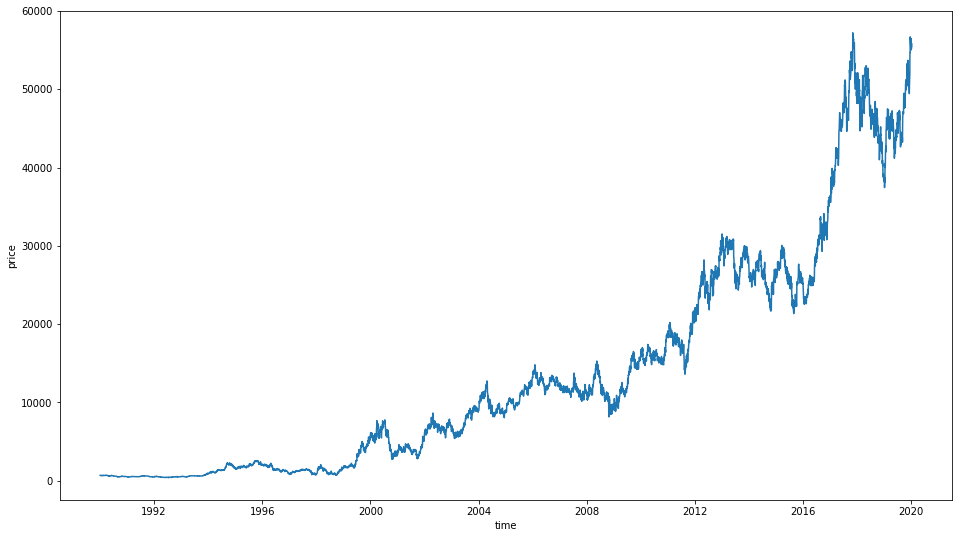

In [93]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['종가'], x=df['일자'])
plt.xlabel('time')
plt.ylabel('price')

- 주식 가격은 2000년대 이후로 계속적으로 우상향 하는 것을 확인 할 수 있다. 
  + 삼성전자의 주식은 계속 오를까?
  + 언제까지 오를까?
  + 삼성전자의 주식이 큰폭으로 떨어지던 시기에는 무슨일이 있던 것일까?

### (3) 데이터 정규화
- 이제 데이터 정규화를 진행하도록 한다. 

In [94]:
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,시가,고가,저가,종가,거래량
0,0.968482,0.980394,0.979423,0.975012,0.030291
1,0.954474,0.966389,0.961684,0.969733,0.031470
2,0.973735,0.983895,0.967005,0.969733,0.047217
3,0.964980,0.973391,0.968779,0.964454,0.039781
4,0.977237,0.983895,0.981197,0.975012,0.025585
...,...,...,...,...,...
7823,0.005095,0.005094,0.005073,0.004927,0.002960
7824,0.005165,0.005129,0.005215,0.005068,0.005279
7825,0.005236,0.005199,0.005162,0.005015,0.005483
7826,0.005236,0.005339,0.005286,0.005279,0.008384


- 정규화는 왜 하는 것일까?
  + 정규화는 무엇인가?
  + 정규화(MinMaxScaler)를 해주면 전체 데이터는 0, 1사이의 값을 갖도록 해준다. 

### (4) 시계열 데이터의 데이터셋 분리
- 시계열 데이터의 데이터셋은 보통 `window_size`라고 정의한다. 
  + `window_size`는 과거 기간의 주가 데이터에 기반하여 다음날의 종가를 예측할 것인가를 정하는 `parameter`이다. 
  + 만약 과거 20일을 기반으로 내일 데이터를 예측한다라고 가정하면 `window_size=20`이 되는 것이다. 
- 실제 `100`일의 과거 데이터를 기반으로 데이터셋을 분리하도록 한다. 
- 이 때, `make_dataset`이라는 함수를 만든다. 
  + feature_list & label list를 분리한다. 

In [95]:
TEST_SIZE = 200
WINDOW_SIZE = 20

train = df_scaled[:-TEST_SIZE]
train

,시가,고가,저가,종가,거래량
0,0.968482,0.980394,0.979423,0.975012,0.030291
1,0.954474,0.966389,0.961684,0.969733,0.031470
2,0.973735,0.983895,0.967005,0.969733,0.047217
3,0.964980,0.973391,0.968779,0.964454,0.039781
4,0.977237,0.983895,0.981197,0.975012,0.025585
...,...,...,...,...,...
7623,0.001751,0.001716,0.001827,0.001707,0.001409
7624,0.001856,0.001768,0.001827,0.001707,0.002111
7625,0.001856,0.001751,0.001792,0.001813,0.006075
7626,0.001874,0.001768,0.001792,0.001813,0.007916


In [96]:
test = df_scaled[-TEST_SIZE:]
test.head()

,시가,고가,저가,종가,거래량
7628,0.002014,0.002048,0.001934,0.001813,0.001979
7629,0.001751,0.001873,0.001738,0.001936,0.002689
7630,0.001628,0.001646,0.001703,0.001584,0.001365
7631,0.001558,0.001716,0.001632,0.001584,0.009585
7632,0.002119,0.002013,0.001898,0.001777,0.002663


- `TEST_SIZE = 200`은 학습은 과거부터 200일 이전의 데이터를 학습하게 되고, TEST를 위해서 이후 100일의 데이터로 모델이 주가를 예측하도록 한 다음, 실제 데이터와 오차가 얼마나 있는지 확인해 보도록 하겠습니다.

In [97]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

- 이렇게 만든 함수를 이제 훈련데이터와 테스트데이터로 분리를 하도록 한다. 

In [98]:
feature_cols = ['시가', '고가', '저가', '거래량']
label_cols = ['종가']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((6086, 20, 4), (1522, 20, 4))

In [99]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((200, 4), (200, 1))

In [100]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((180, 20, 4), (180, 1))

### (5) 모형 학습
- 이제 `Keras` 모형을 생성하여 학습을 진행합니다. 
- 먼저 모형을 만듭니다. 

In [101]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

- 이제 모형을 학습합니다. 

In [102]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
376/381 [============================>.] - ETA: 0s - loss: 0.0071
Epoch 00001: val_loss improved from inf to 0.00011, saving model to model/tmp_checkpoint.h5
381/381 [==============================] - 3s 8ms/step - loss: 0.0071 - val_loss: 1.1343e-04
Epoch 2/200
375/381 [============================>.] - ETA: 0s - loss: 9.3076e-05
Epoch 00002: val_loss did not improve from 0.00011
381/381 [==============================] - 3s 7ms/step - loss: 9.3133e-05 - val_loss: 1.2260e-04
Epoch 3/200
378/381 [============================>.] - ETA: 0s - loss: 8.1114e-05
Epoch 00003: val_loss improved from 0.00011 to 0.00008, saving model to model/tmp_checkpoint.h5
381/381 [==============================] - 3s 8ms/step - loss: 8.1019e-05 - val_loss: 7.7643e-05
Epoch 4/200
377/381 [============================>.] - ETA: 0s - loss: 7.3804e-05
Epoch 00004: val_loss improved from 0.00008 to 0.00006, saving model to model/tmp_checkpoint.h5
381/381 [==============================] - 3s 8ms/step

### (6) 주가 예측 
- `predict()`를 활용하여 모형을 예측한다. 

In [103]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

(180, 1)

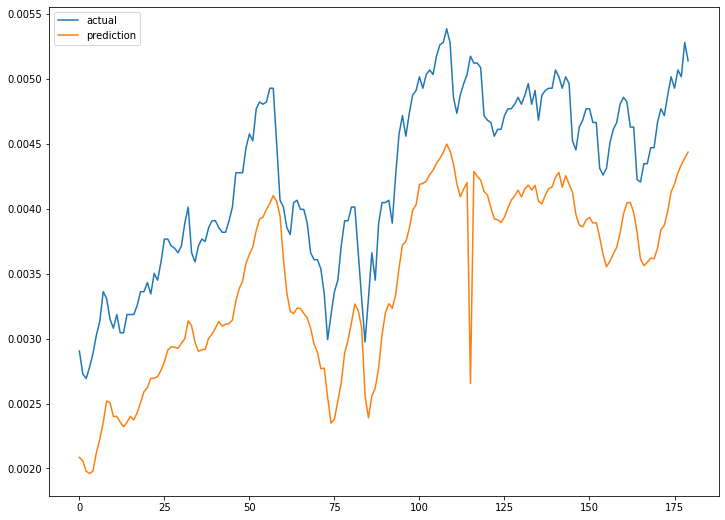

In [104]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()